In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score, f1_score
from dhg import Hypergraph
from dhg.data import *
from dhg.models import *
from dhg.random import set_seed
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score


/users/Min/miniconda/envs/hyper/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

data = CocitationCora()
G = Hypergraph(data["num_vertices"], data["edge_list"])
print(G)


A = G.H @ G.H.T
# print(A)

# 将稀疏张量转换为标准的邻接矩阵表示
adj_matrix = torch.sparse_coo_tensor(A.indices(), A.values(), A.size())

# 计算每个节点的度
degree_list = adj_matrix.to_dense().sum(dim=1)
degree_list = degree_list.cpu().numpy().tolist()


# # 设置随机种子，以确保结果可复现
random_seed = 42

node_idx = [i for i in range(data['num_vertices'])]
# 将idx_test划分为训练（50%）、验证（25%）和测试（25%）集
idx_train, idx_temp = train_test_split(node_idx, test_size=0.5, random_state=random_seed)
idx_val, idx_test = train_test_split(idx_temp, test_size=0.5, random_state=random_seed)

# 确保划分后的集合没有重叠
assert len(set(idx_train) & set(idx_val)) == 0
assert len(set(idx_train) & set(idx_test)) == 0
assert len(set(idx_val) & set(idx_test)) == 0

train_mask = torch.zeros(data['num_vertices'], dtype=torch.bool)
val_mask = torch.zeros(data['num_vertices'], dtype=torch.bool)
test_mask = torch.zeros(data['num_vertices'], dtype=torch.bool)
train_mask[idx_train] = True
val_mask[idx_val] = True
test_mask[idx_test] = True


v_deg= G.D_v

# X = v_deg.to_dense()/torch.max(v_deg.to_dense())
X = data["features"]
lbls = data["labels"]
print('X dim:', X.shape)
print('labels:', len(torch.unique(lbls)))


set_seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

net = HGNN(X.shape[1], 32, data["num_classes"], use_bn=True)
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay=5e-4)

X, lbls = X.to(device), lbls.to(device)
G = G.to(device)
net = net.to(device)

Hypergraph(num_v=2708, num_e=1483)
X dim: torch.Size([2708, 1433])
labels: 7


In [4]:

# 从文件中读取预测结果
predicted_array = np.loadtxt('res/predicted_cocitationcora.txt', dtype=int)
# 将numpy数组转换为列表
predicted_labels = predicted_array.tolist()
true_labels = lbls[test_mask].cpu().numpy().tolist()


predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)
# 计算每个节点的ACC
trues = (predicted_labels == true_labels).astype(int)
errors = [1 if value == 0 else 0 for value in trues]

degree_counts = {}
filtered_data = [(degree, value1, value2) for degree, value1, value2 in zip(degree_list, trues, errors) if 0 <= degree <= 3]

# Populate the dictionary
for degree, value1, value2 in filtered_data:
    if degree not in degree_counts:
        degree_counts[degree] = {'ones': 0, 'zeros': 0, 'total': 0}
    degree_counts[degree]['ones'] += value1
    degree_counts[degree]['zeros'] += value2
    degree_counts[degree]['total'] += 1

# Calculate the probabilities
hgnn_degree_probabilities_list1 = [degree_counts.get(degree, {'ones': 0})['ones'] / degree_counts.get(degree, {'total': 1})['total'] for degree in range(1,4)]
# hgnn_degree_probabilities_list2 = [degree_counts.get(degree, {'zeros': 0})['zeros'] / degree_counts.get(degree, {'total': 1})['total'] for degree in range(1,6)]


In [5]:

# 从文件中读取预测结果
predicted_array = np.loadtxt('res/lahgnn_predicted_cocitationcora.txt', dtype=int)
# 将numpy数组转换为列表
predicted_labels = predicted_array.tolist()
true_labels = lbls[test_mask].cpu().numpy().tolist()


predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)
# 计算每个节点的ACC
trues = (predicted_labels == true_labels).astype(int)
errors = [1 if value == 0 else 0 for value in trues]

lahgnn_degree_counts = {}
filtered_data = [(degree, value1, value2) for degree, value1, value2 in zip(degree_list, trues, errors) if 0 <= degree <= 3]

# Populate the dictionary
for degree, value1, value2 in filtered_data:
    if degree not in degree_counts:
        degree_counts[degree] = {'ones': 0, 'zeros': 0, 'total': 0}
    lahgnn_degree_counts[degree]['ones'] += value1
    lahgnn_degree_counts[degree]['zeros'] += value2
    lahgnn_degree_counts[degree]['total'] += 1

# Calculate the probabilities
lahgnn_degree_probabilities_list1 = [degree_counts.get(degree, {'ones': 0})['ones'] / degree_counts.get(degree, {'total': 1})['total'] for degree in range(1,4)]
# hgnn_degree_probabilities_list2 = [degree_counts.get(degree, {'zeros': 0})['zeros'] / degree_counts.get(degree, {'total': 1})['total'] for degree in range(1,4)]


ValueError: operands could not be broadcast together with shapes (542,) (677,) 

In [11]:
# 使用 sorted 函数进行排序
sorted_list = sorted(list(set((sorted(degree_list)))))

# 输出排序后的列表
print(sorted_list[:5])

[0.0, 2.0, 3.0, 4.0, 5.0]


In [12]:
from collections import Counter
# 使用 Counter 统计度值的频数
degree_counts = Counter(degree_list)
print(min(degree_list),max(degree_list))
# 计算每个度值对应的比例
total_nodes = len(degree_list)
degree_probabilities = {degree: count / total_nodes for degree, count in degree_counts.items()}

ratio_num_neighbors = list(degree_probabilities.values())
ratio_num_neighbors

0.0 405.0


[0.02326440177252585,
 0.4704579025110783,
 0.014401772525849335,
 0.06683899556868537,
 0.05945347119645495,
 0.06462333825701624,
 0.0011078286558345643,
 0.0048005908419497785,
 0.014401772525849335,
 0.0568685376661743,
 0.02031019202363368,
 0.004431314623338257,
 0.014771048744460856,
 0.03508124076809453,
 0.001846381093057607,
 0.0258493353028065,
 0.009601181683899557,
 0.0051698670605613,
 0.00036927621861152144,
 0.0066469719350073855,
 0.003692762186115214,
 0.0007385524372230429,
 0.00036927621861152144,
 0.024741506646971934,
 0.004431314623338257,
 0.005908419497784343,
 0.005908419497784343,
 0.0007385524372230429,
 0.00036927621861152144,
 0.0007385524372230429,
 0.00036927621861152144,
 0.0011078286558345643,
 0.001846381093057607,
 0.00258493353028065,
 0.001846381093057607,
 0.0066469719350073855,
 0.004062038404726735,
 0.00036927621861152144,
 0.009601181683899557,
 0.00036927621861152144,
 0.00036927621861152144,
 0.00036927621861152144,
 0.0011078286558345643,
 

In [ ]:

# Plot the results
width = 0.35
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(np.arange(1,6), hgnn_degree_probabilities_list1, width, label='Ratio of True Predictions by HGNN model', color='#FFA2A5', edgecolor='#FF0000',alpha=0.7)
ax.bar(np.arange(1,6), lahgnn_degree_probabilities_list1, width, label='Ratio of False Predictions by GA-HGNN model', color='#A7A7FF', edgecolor='#0000FF',alpha=0.7, bottom=hgnn_degree_probabilities_list1)
ax.set_xlabel('Number of neighbor nodes (1-3)')
ax.set_ylabel('Probability')
ax.grid(True, linestyle='--', alpha=0.5)
# ax.set_title('Ratio distribution of True and False predictions')
ax.legend(fontsize=12)
plt.savefig('figs/gahgnn_hgnn_deg_acc_cocitationcora.pdf')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 第一组数据
x1 = np.array([1, 2, 3])
ratio1 = np.array(ratio_num_neighbors[1:4])
accuracy1 = np.array(hgnn_degree_probabilities_list1)

# 第二组数据
x2 = np.array([1, 2, 3])
accuracy2 = np.array(lahgnn_degree_probabilities_list1)

fig, ax1 = plt.subplots()
# 绘制第一组柱状图（左边）
ax1.set_xlabel('Number of neighbor nodes (1-3)')
ax1.set_ylabel('Percentage(%)')

ax1.bar(x1, ratio1, color='#4995c6', align='center', label='Percentage')
# ax1.tick_params(axis='y', labelcolor='tab:blue')

# 绘制第二组柱状图（左边）
# ax1.bar(x2 + 0.2, quantity1, width=0.4, color='tab:green', align='center', label='Quantity 2')

# 创建第二个纵坐标轴（右边）
ax2 = ax1.twinx()
ax2.set_ylabel('True Predictions')
ax2.plot(x1, accuracy1, marker='o', color='#FAbb61', alpha=0.7, linestyle='-', linewidth=2, markersize=8, label='HGNN')
ax2.plot(x2, accuracy2, marker='s', color='#Addb88', alpha=0.7, linestyle='--', linewidth=2, markersize=8, label='GA-HGNN')
# ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.legend()
plt.show()

#### hidden size param ana

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (2,).

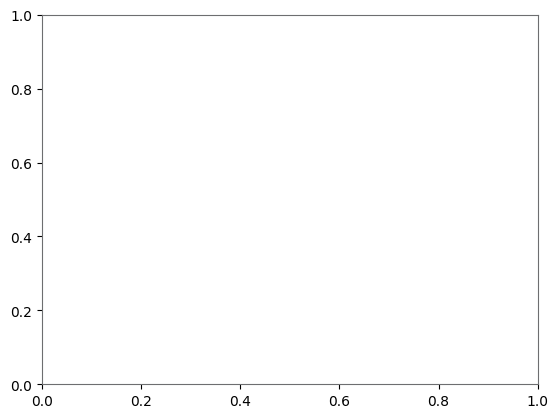

In [16]:
import matplotlib.pyplot as plt
import numpy as np



import seaborn as sns
sns.set_palette(sns.color_palette('bwr')) #PuBuGn_r PuBu_r Set1_r YlGnBu_r bwr cool_r


# 数据
categories = [8, 16, 32,64]
values = [
    [0.5230, 0.5339, 0.5315, 0.5326],
    [0.5025, 0.5086, 0.5073, 0.5086]
]


fig=plt.figure()

plt.grid()
ax = plt.gca()

ax.grid(False)  # 删除网格线
ax.spines['top'].set_color('#6D6E70')
ax.spines['bottom'].set_color('#6D6E70')
ax.spines['left'].set_color('#6D6E70')
ax.spines['right'].set_color('#6D6E70')

# 绘制柱形图
colors = ['#FAbb61','#Addb88']
labels = ['Accuracy', 'Macro-F1 Socre']
data = list(zip(*values))
num_datasets = len(data)
width = 0.14  # 柱形的宽度
x = np.arange(len(categories))  # x 轴坐标位置

for i in range(len(data)):
    ax.bar(x + (i - (num_datasets - 1) / 2) * width, data[i], width, label=labels[i], color=colors[i])


# ax.set_xlabel('Categories')
# ax.set_ylabel('Values')
# ax.set_title('Comparison of A, B, C, and D')
ax.set_xticks(x + width * (len(values) - 1) / 2)
ax.set_xticklabels(categories)
ax.legend()

plt.xlabel('Hidden size', fontsize='large')
plt.ylabel('Metrics', fontsize='large')
plt.title('Results of GA-HGNN', fontsize='large', pad=10)

plt.legend()
plt.show()
